In [1]:
import numpy as np

import matplotlib.pyplot as plt
from h5py import File
%matplotlib inline

from jax import numpy as jnp
import jax
from tqdm import tqdm

from scipy.optimize import fmin_powell
from numpyro.infer import MCMC, NUTS, util, init_to_median

import csiborgtools
import corner

%load_ext autoreload
%autoreload 2


paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

## LOS density & radial velocity plots 

In [14]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00, 84.48it/s]


10:20:19: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 21608.99it/s]


10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 101/101 [00:02<00:00, 42.58it/s]


10:20:21: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 351.66it/s]


10:20:22: reading the catalogue.
10:20:22: reading the interpolated field.


100%|██████████| 20/20 [00:00<00:00, 123.83it/s]


10:20:22: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 1285.41it/s]


In [2]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [174]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "csiborg1"
catalogue = "2MTF"
loader = csiborgtools.flow.DataLoader(simname, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.06}

16:28:25: reading the catalogue.
16:28:25: reading the interpolated field.


100%|██████████| 101/101 [00:21<00:00,  4.68it/s]
/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:108: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


16:28:46: calculating the radial velocity.


100%|██████████| 1248/1248 [00:02<00:00, 441.14it/s]


### Maximizing the log-likelihood

In [137]:
samples, stats, fmin, logz, bic = csiborgtools.flow.optimize_model_with_jackknife(loader, 19, 5, True, get_model_kwargs=get_model_kwargs)


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


In [138]:
print("Log Z: ")
print(np.mean(logz), np.std(logz))

print("BIC: ")
print(np.mean(bic), np.std(bic))

print("beta: ")
print(*stats["beta"])

Log Z: 
-720.9279427394929 3.501431137265503
BIC: 
1496.4595387739434 6.356325506551423
beta: 
0.9214629141858417 0.2800670163219086


#### Running HMC

In [176]:
model = csiborgtools.flow.get_model(loader, k=30, **get_model_kwargs)

Selected 1248/1248 galaxies.


In [178]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=500)

rng_key = jax.random.PRNGKey(5)

In [179]:
mcmc.run(rng_key, sample_alpha=True)

sample: 100%|██████████| 750/750 [03:36<00:00,  3.47it/s, 7 steps of size 4.64e-01. acc. prob=0.91]  


In [180]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          Vext_x     82.64     22.65     82.44     42.11    119.99    503.40      1.00
          Vext_y   -195.75     24.46   -195.33   -236.00   -155.73    647.07      1.00
          Vext_z   -306.00     25.02   -305.94   -347.13   -267.32    425.43      1.00
               a    -22.28      0.02    -22.28    -22.30    -22.25    493.19      1.00
           alpha      0.52      0.04      0.52      0.46      0.58    588.72      1.00
               b     -6.31      0.09     -6.31     -6.44     -6.17    510.16      1.00
            beta      0.95      0.05      0.95      0.87      1.03    678.00      1.00
  e_mu_intrinsic      0.40      0.01      0.40      0.38      0.42    406.23      1.00
         sigma_v    227.07     15.02    226.96    199.16    248.31    636.71      1.00

Number of divergences: 0


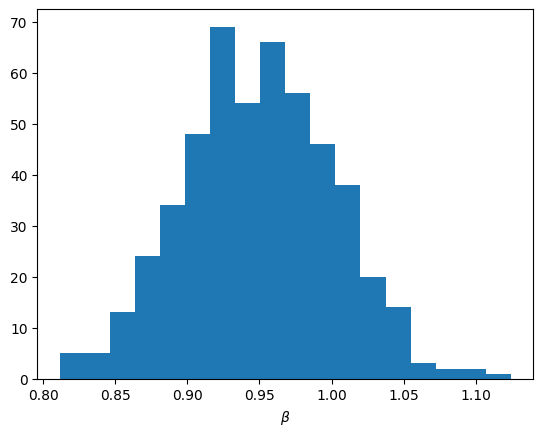

In [181]:
plt.figure()
plt.hist(samples["beta"], bins="auto")
plt.xlabel(r"$\beta$")
plt.show()

In [182]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

In [183]:
print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 373.878173828125 +- 27.086021423339844
l    = 342.21601176361986 +- 4.145220888130849
b    = -27.483255950082246 +- 3.1987615901961264
beta = 0.9494613409042358 +- 0.05187663435935974


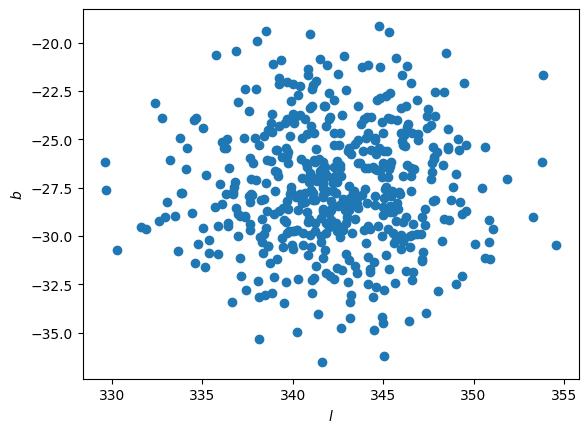

In [184]:
plt.figure()
plt.scatter(l, b)
plt.xlabel(r"$l$")
plt.ylabel(r"$b$")
plt.show()

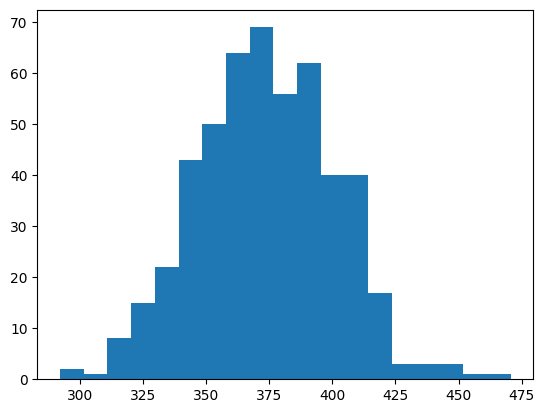

In [185]:
plt.figure()
plt.hist(V[:, 0], bins="auto")
plt.show()

In [172]:
if "alpha" in samples:
    data = np.vstack([samples["alpha"], samples["beta"], l, b, Vmag]).T
    labels = [r"$\alpha$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
else:
    data = np.vstack([samples["beta"], l, b, Vmag]).T
    labels = [r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

# keys = samples.keys()
# data = np.vstack([samples[key] for key in keys]).T
# labels = list(keys)


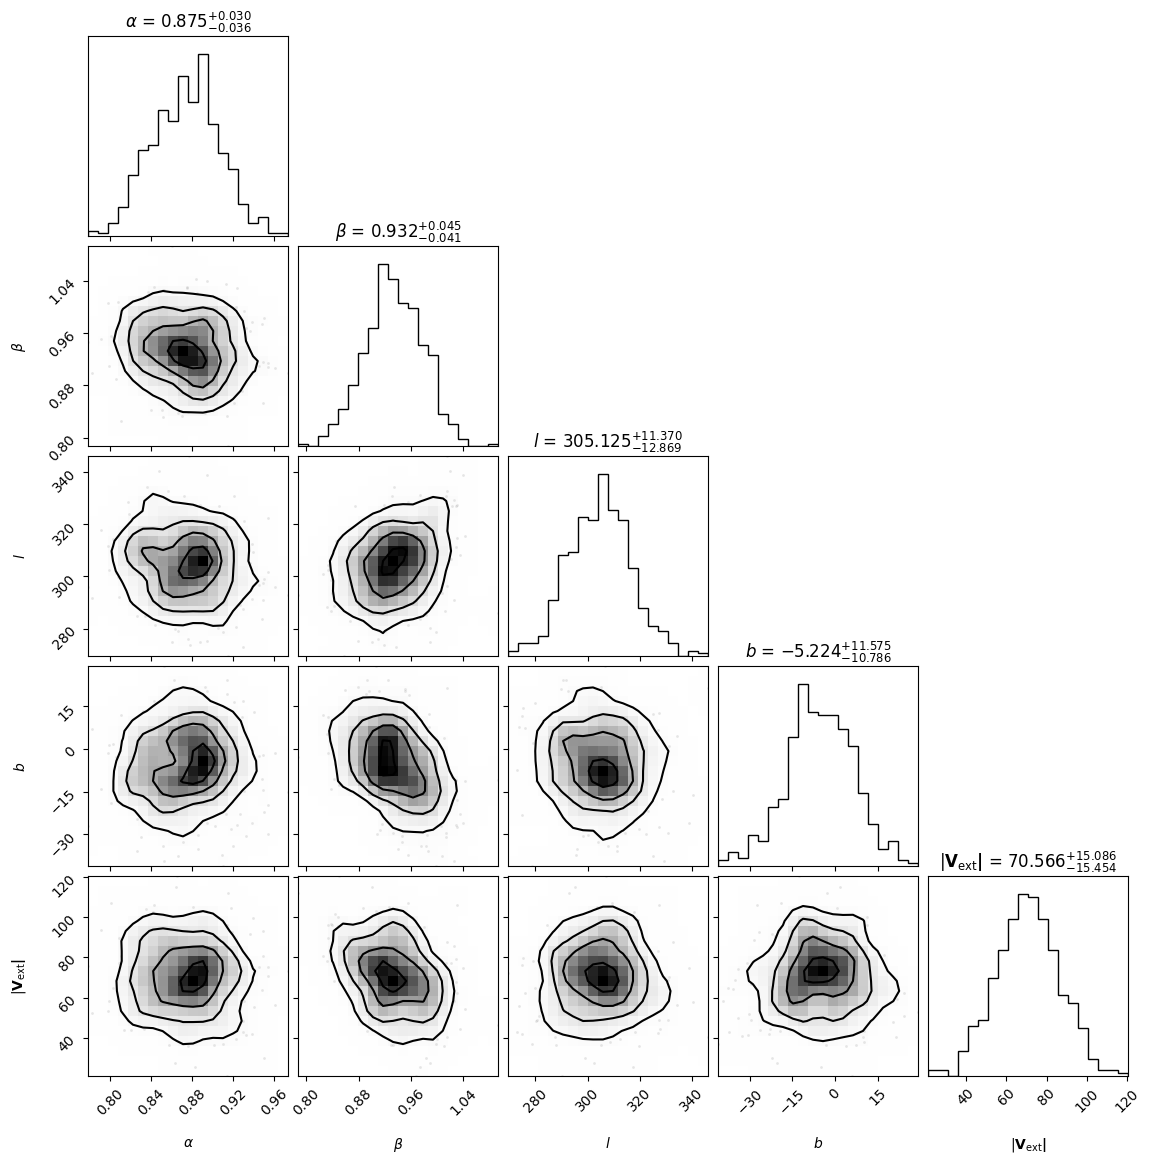

In [173]:
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)
fig.savefig(f"../plots/corner.png", dpi=300, bbox_inches="tight")

## Vizualize the results

In [17]:
paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
catalogue = "LOSS"
simname = "csiborg2_random"

nsims = paths.get_ics(simname)

Vx = []
Vy = []
Vz = []
beta = []
sigma_v = []
alpha = []

alpha_cal = []
beta_cal = []
mag_cal = []
e_mu_intrinsic = []


with File(f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_{catalogue}_{simname}_smooth_0.hdf5", 'r') as f:
    for i, nsim in enumerate(tqdm(nsims)):
        if i == 0:
            print(f[f"sim_{nsim}"].keys())

        Vx.append(f[f"sim_{nsim}/Vext_x"][:])
        Vy.append(f[f"sim_{nsim}/Vext_y"][:])
        Vz.append(f[f"sim_{nsim}/Vext_z"][:])
        alpha.append(f[f"sim_{nsim}/alpha"][:])
        beta.append(f[f"sim_{nsim}/beta"][:])
        sigma_v.append(f[f"sim_{nsim}/sigma_v"][:])

        alpha_cal.append(f[f"sim_{nsim}/alpha_cal"][:])
        beta_cal.append(f[f"sim_{nsim}/beta_cal"][:])
        mag_cal.append(f[f"sim_{nsim}/mag_cal"][:])
        e_mu_intrinsic.append(f[f"sim_{nsim}/e_mu_intrinsic"][:])

Vx = np.hstack(Vx)
Vy = np.hstack(Vy)
Vz = np.hstack(Vz)
alpha = np.hstack(alpha)
beta = np.hstack(beta)
sigma_v = np.hstack(sigma_v)

alpha_cal = np.hstack(alpha_cal)
beta_cal = np.hstack(beta_cal)
mag_cal = np.hstack(mag_cal)
e_mu_intrinsic = np.hstack(e_mu_intrinsic)

Vmag = np.sqrt(Vx**2 + Vy**2 + Vz**2)

V = np.vstack([Vx, Vy, Vz]).T
V = csiborgtools.cartesian_to_radec(V)
l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])


data = np.vstack([alpha, beta, Vmag, l, b, sigma_v, alpha_cal, beta_cal, mag_cal, e_mu_intrinsic]).T
labels = [r"$\alpha$", r"$\beta$", r"$|\bf{V}_{\rm ext}|$", r"$l$", r"$b$", r"$\sigma_v$", r"$\alpha_{\rm cal}$", r"$\beta_{\rm cal}$", r"$M$", r"$\sigma_\mu$"]

100%|██████████| 20/20 [00:00<00:00, 113.74it/s]


<KeysViewHDF5 ['Vext_x', 'Vext_y', 'Vext_z', 'alpha', 'alpha_cal', 'beta', 'beta_cal', 'e_mu_intrinsic', 'mag_cal', 'sigma_v']>


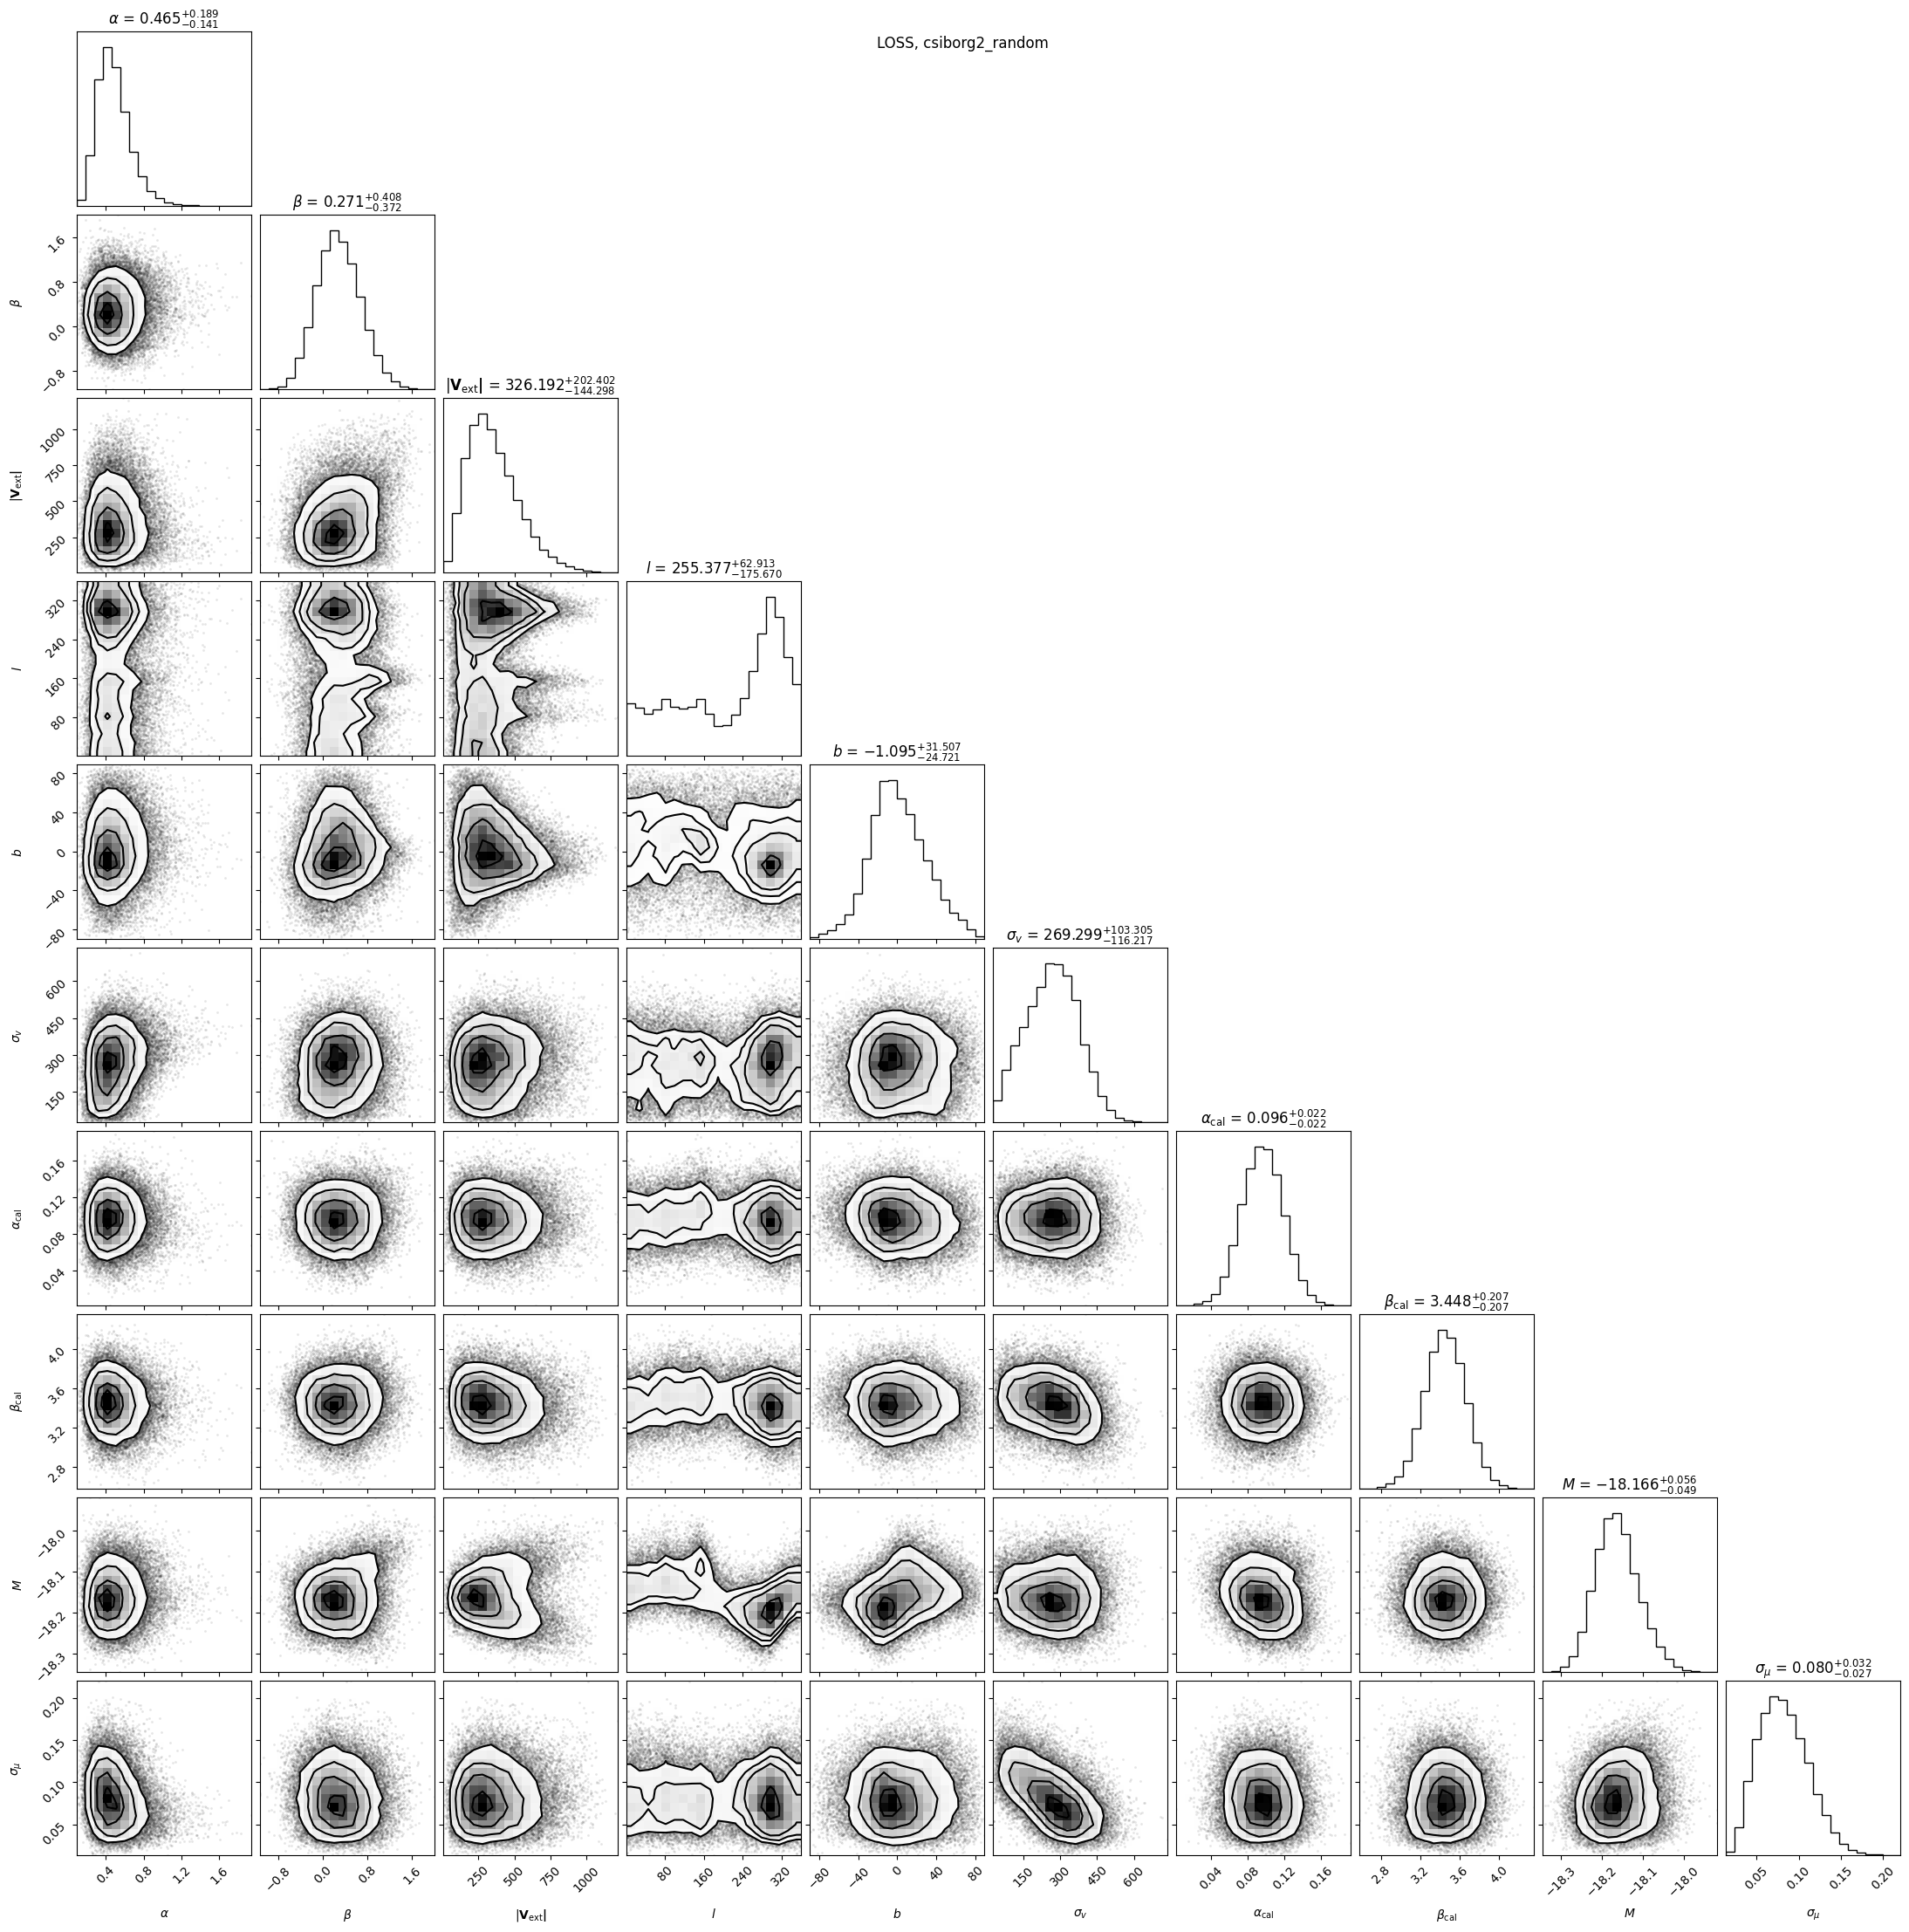

In [18]:
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12})
fig.suptitle(f"{catalogue}, {simname}")
fig.savefig(f"../plots/corner_{catalogue}_{simname}.png", dpi=300, bbox_inches="tight")

In [210]:
np.mean(l)

294.53874356626227

In [299]:
0.906 * 0.43

0.38958

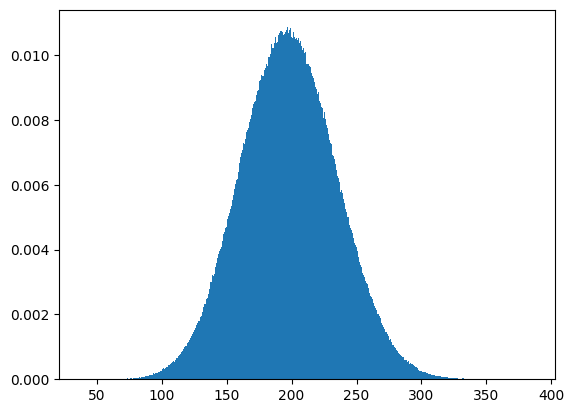

In [214]:
plt.figure()
plt.hist(V[:, 0], bins="auto", density=True)
plt.show()

In [219]:
print(beta.mean(), beta.std())
print(np.mean(V[:, 0]), np.std(V[:, 0]))
print(l.mean(), b.mean())

0.61461765 0.095553815
198.02641 36.928383
294.53874356626227 -5.542468825545464


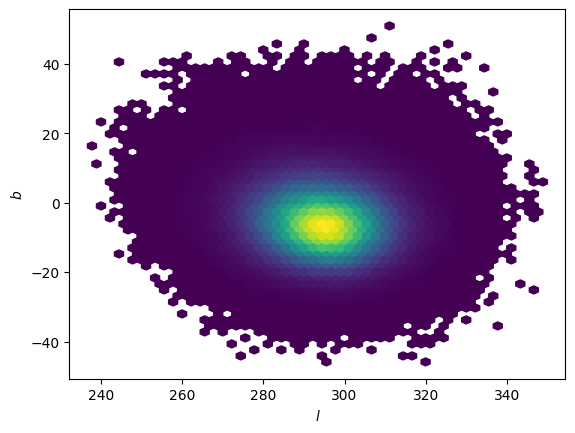

In [213]:
plt.figure()
plt.hexbin(l, b, gridsize=50, mincnt=1)
plt.xlabel(r"$l$")
plt.ylabel(r"$b$")
plt.show()

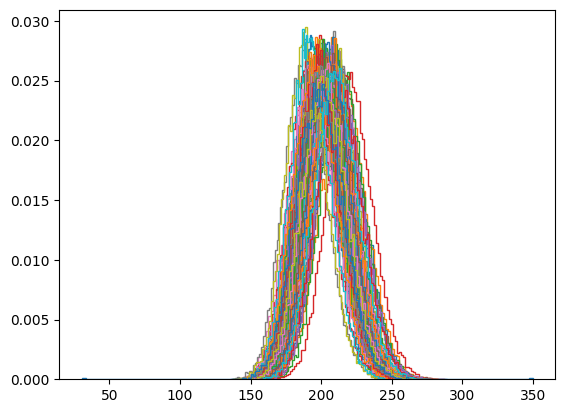

In [130]:
plt.figure()
for i in range(len(x)):
    plt.hist(x[i], bins="auto", density=True, histtype="step")

plt.show()

## Test bias

In [437]:
from jax.lax import cond

In [488]:


def bias(rho_norm, b):
    def bias_small(rho_norm, b):
        return jnp.log((1 + jnp.exp((1 - b + b * rho_norm))) / (1 + jnp.exp((1 - b))))

    def bias_large(rho_norm, b):
        return 1 - b + b * rho_norm - jnp.log(1 + jnp.exp(1 - b))

    return jnp.where(rho_norm < 3, 
                     bias_small(rho_norm, b), 
                     bias_large(rho_norm, b))

     

In [489]:
rho_norm = jnp.linspace(0, 100, 100)
b = 2
y = bias(rho_norm, b)

In [490]:
y

Array([  0.       ,   1.0148089,   2.7738497,   4.7473445,   6.767546 ,
         8.787747 ,  10.80795  ,  12.828152 ,  14.848353 ,  16.868557 ,
        18.888758 ,  20.90896  ,  22.929163 ,  24.949364 ,  26.969566 ,
        28.989767 ,  31.00997  ,  33.03017  ,  35.050373 ,  37.07057  ,
        39.090775 ,  41.110977 ,  43.13118  ,  45.151382 ,  47.171585 ,
        49.191784 ,  51.211987 ,  53.23219  ,  55.25239  ,  57.272594 ,
        59.292793 ,  61.312996 ,  63.3332   ,  65.3534   ,  67.373604 ,
        69.39381  ,  71.41401  ,  73.43421  ,  75.45441  ,  77.47461  ,
        79.49481  ,  81.515015 ,  83.53522  ,  85.55542  ,  87.57562  ,
        89.595825 ,  91.61603  ,  93.63623  ,  95.65643  ,  97.67663  ,
        99.69683  , 101.71703  , 103.737236 , 105.75744  , 107.77764  ,
       109.797844 , 111.81805  , 113.83825  , 115.85845  , 117.87865  ,
       119.89885  , 121.91905  , 123.939255 , 125.95946  , 127.97966  ,
       129.99986  , 132.02007  , 134.04027  , 136.06047  , 138.0

In [485]:
bias_small(rho_norm, b)

Array([ 0.       ,  1.0148089,  2.7738497,  4.753666 ,  6.768387 ,
        8.787859 , 10.807965 , 12.828154 , 14.848354 , 16.868557 ,
       18.888758 , 20.90896  , 22.929163 , 24.949364 , 26.969566 ,
       28.989767 , 31.00997  , 33.03017  , 35.050373 , 37.07057  ,
       39.090775 , 41.110977 , 43.13118  , 45.151382 , 47.171585 ,
       49.191784 , 51.211987 , 53.23219  , 55.25239  , 57.272594 ,
       59.292793 , 61.312996 , 63.3332   , 65.3534   , 67.373604 ,
       69.39381  , 71.41401  , 73.43421  , 75.45441  , 77.47461  ,
       79.49481  , 81.515015 , 83.53522  , 85.55542  , 87.57562  ,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        

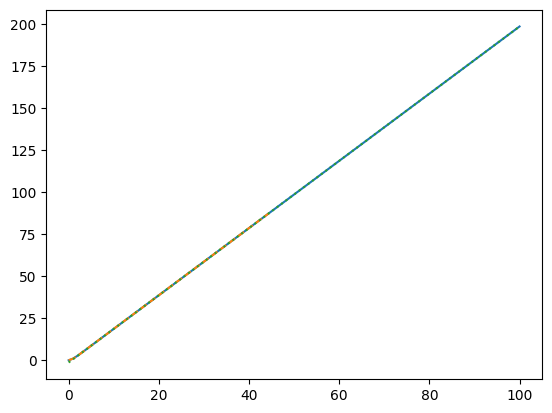

In [487]:
plt.figure()
plt.plot(rho_norm, y)
plt.plot(rho_norm, bias_small(rho_norm, b), ls="--")
plt.plot(rho_norm, bias_large(rho_norm, b), ls="dotted")
plt.show()

In [462]:
bias(loader._los_density[0], 2.)

Array([[1.3646735 , 1.434935  , 1.5887474 , 1.6949235 , 1.7769545 ,
        1.8709289 , 2.0290222 , 2.1513133 , 2.2334485 , 2.329708  ,
        2.444497  , 2.5160108 , 2.5457559 , 2.5692239 , 2.608365  ,
        2.6157517 , 2.5902514 , 2.5320826 , 2.4516525 , 2.3783646 ,
        2.3570633 , 2.2927842 , 2.235333  , 2.1849432 , 2.131144  ,
        2.1050715 , 2.1284485 , 2.1777897 , 2.2121887 , 2.2108288 ,
        2.2272425 , 2.2835732 , 2.2929268 , 2.2634182 , 2.241768  ,
        2.2274647 , 2.1347542 , 2.0022526 , 1.8764566 , 1.757152  ,
        1.5877327 , 1.4179734 , 1.2245289 , 1.0326    , 0.83725584,
        0.9779409 , 0.8560009 , 0.7459278 , 0.64249325, 0.5510863 ,
        0.4705007 , 0.40490875, 0.3523176 , 0.3036849 , 0.25979096,
        0.22670034, 0.2001784 , 0.17650758, 0.15544249, 0.1421564 ,
        0.1319982 , 0.12369715, 0.11719201, 0.11655279, 0.1178802 ,
        0.12243555, 0.12922992, 0.13944156, 0.15134403, 0.16509394,
        0.1822752 , 0.20241688, 0.22445495, 0.24

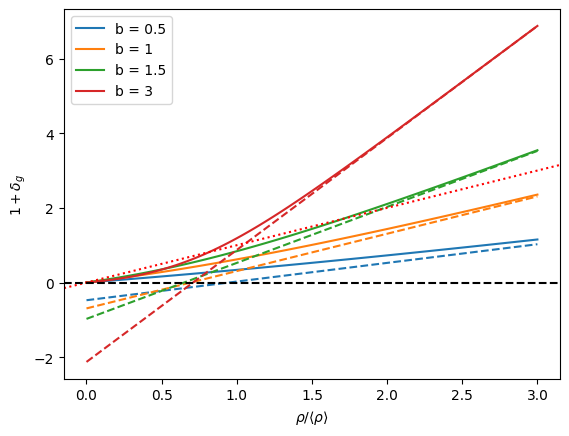

In [436]:
b = 1.4

rho = np.linspace(0, 3, 100)

def bias(rho, b):
    return np.log((1 + np.exp((1 - b + b * rho))) / (1 + np.exp((1 - b))))

def linear_bias(rho, b):
    return (1 - b + b * rho)

plt.figure()
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, b in enumerate([0.5, 1, 1.5, 3]):
    plt.plot(rho, bias(rho, b), label=f"b = {b}", c=cols[i])
    plt.plot(rho, 1 - b + b * rho - np.log(1 + np.exp(1 - b)), ls="--", c=cols[i])
    # plt.plot(rho, linear_bias(rho, b), ls="--", c=cols[i])
    

plt.axline((1, 1), slope=1, color="red", linestyle="dotted")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel(r"$\rho / \langle \rho \rangle$")
plt.ylabel(r"$1 + \delta_g$")
plt.legend()
plt.show()


In [133]:
 def get_field(kind):
    folder = "/mnt/extraspace/rstiskalek/catalogs"
    from os.path import join
    if kind == "density":
        fpath = join(folder, "twompp_density_carrick2015.npy")
        return np.load(fpath).astype(np.float32)
    elif kind == "velocity":
        fpath = join(folder, "twompp_velocity_carrick2015.npy")
        field = np.load(fpath).astype(np.float32)

        # Because the Carrick+2015 data is in the following form:
        # "The velocities are predicted peculiar velocities in the CMB
        # frame in Galactic Cartesian coordinates, generated from the
        # \(\delta_g^*\) field with \(\beta^* = 0.43\) and an external
        # dipole \(V_\mathrm{ext} = [89,-131,17]\) (Carrick et al Table 3)
        # has already been added.""
        field[0] -= 89
        field[1] -= -131
        field[2] -= 17
        field /= 0.43

        return field

In [135]:
density = get_field("density")
velocity = get_field("velocity")

In [136]:
from h5py import File

In [137]:
with File("/mnt/extraspace/rstiskalek/catalogs/Carrick2015_unscaled.hdf5", 'w') as f:
    f.create_dataset("density", data=density)
    f.create_dataset("velocity", data=velocity)
    